In [51]:
# Initialize Otter
import otter
grader = otter.Notebook("fountain_codes.ipynb")

In [52]:
# if needed
%pip install -r requirements.txt
# Restart kernel if needed

Note: you may need to restart the kernel to use updated packages.


# Codes for Efficient Transmission of Data

## Introduction 

When sending packets of data over a communication channel such as the internet or a radio channel, packets often get erased. Because of this, packets must be sent under some erasure code such that the data can still be recovered. In CS 70, you may have learned about an erasure code that involves embedding the data in a polynomial, and then sampling points from that polynomial. There, we assumed that there were at most $k$ erasures in the channel. This week, we'll explore a different channel model in which each packet independently has a probability $p$ of being erased. In particular, this lab will look at random bipartite graphs (the balls and bins model).

A little more on the channel and the erasure code; formally, our channel is called the binary erasure channel (BEC), where bits that are sent through a noisy channel either make it through unmodified or are tagged as "corrupt", in which case the received information is dropped in all further information processing steps. Here's an image that shows what happens:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Binary_erasure_channel.svg/156px-Binary_erasure_channel.svg.png" style="background-color: white; padding: 10px"></center>

If we wanted to convey a message, we could consider a feedback channel in which the receiver tells the sender which messages were received and the sender re-sends the dropped packets. This process can be repeated until the receiver gets all of the intended message. While this procedure is indeed optimal in all senses of the word, feedback is simply not possible in many circumstances. If Netflix is trying to stream a show chunked into $n$ data chunks to a million people, its servers can't process all the feedback from the users. Thus, Netflix must use a method independent of feedback. If they use near-optimal codes to encode and constantly send out the same random chunks of the video's data to all users, then they can be sure that users get what they need in only a little more than $n$ transmissions *no matter what parts of the show each individual user lost through their specific channel*!

So what's the secret to this magic?  It's a two step process of clever encoding and decoding:

### Encoding
1. Suppose your data can be divided into $n$ chunks. First, pick an integer $d$ ($1 \leq d \leq n$) according to some distribution.
2. With $d$ picked, now select $d$ random chunks of the data and combine their binary representations together using the XOR operator.
3. Transmit these chunks, along with the metadata telling which actual chunk indices were XOR'd, as a packet. If a packet is erased, both the chunks it contains and the chunk indices would be lost. 

### Decoding
1. For each packet that has been received, check if it only contains one chunk, in which case the packet is exactly equal to the single chunk it contains. If not, we can check if any of the chunks in the packet are already known, in which case XOR that chunk with the packet and remove it from the list of chunk indices that make up the packet.
3. If there are two or more indices in the list left for the packet, we cannot figure out any more information!  Put it on the side for looking at later.
4. With any newly decoded information, we may be able to decode previously undecodable packets that we had put on the side.  Go through all unsolved packets and try to decode more packets until nothing more can be done.
5. Wait for the next packet to come and repeat!

Now what's left for you to do?  Well, remember that number $d$?  It needs to be picked according to some distribution, and which distribution is the million dollar question!


### Example
<center><img src="bipartite.png" style="width: 300px;"> </center>

Consider the above bipartite graph. Here, the right square nodes represent the packets, and the left circular nodes represent the data chunks ($X_i, i=1,..,4$). There is an edge from a packet to a chunk if the packet contains that chunk. Let's try decoding the packets chronologically.
1. Since the first packet contains only the third data chunk, we are able to immediately resolve it and find that $X_3=1$.
2. The second packet contains the second and third chunks XOR'd together. Since we already know the third chunk, we can XOR the third chunk ($X_3=1$) with the data packet (0) to get the value of the second data chunk, $X_2=1$.
3. The third packet contains the XOR of data chunks 1, 2, and 4. We have already determined chunks 2 and 3, so we are able to XOR 2 from this packet, but are still left with 1 and 4, and so must move on.
4. With the arrival of the fourth packet, we are able to resolve everything: data chunks 2 and 3 are already determined, and so we are able to XOR chunk 3 ($X_3=1$) with this new data packet (1) to get the value of the chunk 4, $X_4=0$. With this new information, we are able to resolve $X_1$, as packet 3 gave us the equation $1 = X_1 \oplus X_2 \oplus X_4 = X_1 \oplus 1 \oplus 0$. We can solve this to get $X_1 = 0$.
5. We have now solved for all the data chunks, with $X_1 = 0, X_2 = 1, X_3 = 1, X_4 = 0$.

As you might be able to tell, by choosing a good degree distribution for $d$, even when random incoming packets were lost (not shown), you were still able to recover all $4$ symbols only from $4$ received packets, despite the sender not knowing what packets you lost through the BEC.

In [53]:
%matplotlib inline  
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import stats

rng_seed = 0

## Q1. Implementing the Receiver

We've provided you with some starter code, including a `Packet` class, a `Transmitter` class, a `Channel` class, and a `Receiver` class. 

**Your job is to complete the `receive_packet()` function in the `Receiver` class**. 

Feel free to write any additional functions that you may need.

### Packet Class & Utility functions

A packet consists of...
- `chunk_indices`: A list of indices denoting which data chunks are XOR'd together in the packet.
- `data`: The XOR'd data chunks.

In [54]:
def xor(chunks):
    """
    XOR's a collection of chunks, where each chunk is an array.
    """
    tmp = np.zeros(Packet.size_of_packet, 'uint8')
    for each_chunk in chunks:
        tmp = np.bitwise_xor(tmp, each_chunk)
    return tmp

class Packet:
    size_of_packet = 256
    def __init__(self, chunks, chunk_indices):
        self.data = xor(chunks)
        self.chunk_indices = chunk_indices
            
    def num_of_chunks(self):
        return len(self.chunk_indices)

### Channel Class

`Channel` class takes a packet and erases it with probability `eps`.

In [55]:
class Channel:
    def __init__(self, eps):
        self.eps = eps
        self.current_packet = None
        
    def enqueue(self, packet):
        if np.random.random() < self.eps:
            self.current_packet = None
        else:
            self.current_packet = packet
            
    def dequeue(self):
        return self.current_packet

### Transmitter/Encoder Class

You can initiate an encoder with a string! Then, `generate_packet()` will return a randomly encoded packet. 

In our code, the degree $d$ discussed above will be represented by the variable `n_of_chunks`. 
We'll start by considering a very simple degree distribution, which we will call the `single` distribution: the degree $d$ is always equal to 1. 

### Task 1.1: 
Implement the logic when `degree_distribution` is `single`. 


We will implement other distributions in later tasks.

In [56]:
import random


class Transmitter:
    def __init__(self, chunks, channel, degree_distribution):
        self.chunks = chunks
        self.num_chunks = len(chunks)
        self.channel = channel
        self.degree_distribution = degree_distribution
        
    def generate_new_packet(self, num_sent=None):
        """
        Defines the probability distribution for the number of 
        chunks sent in each packet. Optionally may use the number
        of packets already sent as a parameter.
        """
        if self.degree_distribution == 'single':
            # Always give a degree of 1
            # TODO: Q1
            n_of_chunks = 1
        elif self.degree_distribution == 'double':
            # Always give a degree of 2
            # TODO: Q2
            n_of_chunks = 2
        elif self.degree_distribution == 'uniform':
            """
            Randomly assign a degree from between 1 and 5 (inclusive).
            If num_chunks < 5, randomly assign a degree from 
            between 1 and num_chunks
            """
            n_of_chunks = random.randint(1, min(5, self.num_chunks))
        elif self.degree_distribution == 'ideal_soliton':
            # Ideal Soliton distribution
            # TODO: Q3
            n = self.num_chunks
            choices = list(range(1, n+1))
            CDF = []
            CDF.append(1/n)
            for x in range(2, n+1):
                CDF.append(1/n + 1 - 1/x)
            uni = random.random()
            n_of_chunks = choices[0]
            for i in range(n-1):
                if CDF[i] < uni < CDF[i+1]:
                    n_of_chunks = choices[i+1]
        elif self.degree_distribution == 'competition':
            # TODO: Q4
            pass
            n_of_chunks=1
        chunk_indices = list(np.random.randint(self.num_chunks, size=n_of_chunks))
        chunks = [ self.chunks[x] for x in chunk_indices ]
        return Packet( chunks, chunk_indices )
        
    def transmit_one_packet(self, num_sent=None):
        packet = self.generate_new_packet(num_sent)
        self.channel.enqueue( packet )

### Receiver/Decoder Class

You can initiate a decoder with the total number of chunks. Then, `add_packet()` will add a received packet to the decoder.

### Task 1.2
Implement the `receive_packet()` function in the `Receiver` class. 

In [57]:
class Receiver:
    def __init__(self, num_chunks, channel):
        # Total number of chunks to expect.
        self.num_chunks = num_chunks
        
        # List of packets to process.
        self.received_packets = []
        
        # List of decoded chunks, where self.chunks[i] is the original chunk x_i.
        self.chunks = np.zeros((num_chunks, Packet.size_of_packet),dtype=np.uint8)
        
        # Boolean array to keep track of which packets have been found, where self.found[i] indicates
        # if x_i has been found.
        self.found = [ False for x in range(self.num_chunks) ]
        self.channel = channel
        
    def receive_packet(self):
        """
        Processes a new packet and peels off known chunks. 
        Adds the packet to the list of received packets and 
        does extra processing if the packet has a single chunk.
        """
        packet = self.channel.dequeue()
        if packet is not None:
            newData = packet.data
            newIndices = packet.chunk_indices
            # peel known chunks
            for index in packet.chunk_indices:
                if self.found[index]:
                    newData ^= self.chunks[index]
                    newIndices.remove(index)
            packet.data = newData
            packet.chunk_indices = newIndices
            # if redundant drop it
            if len(packet.chunk_indices) == 0:
                pass
            # elif done flag it
            elif len(packet.chunk_indices) == 1:
                index = packet.chunk_indices[0]
                self.chunks[index] = packet.data
                self.found[index] = True
            # else add back to queue
            else:
                self.channel.enqueue(packet)
    
    def peeling(self):
        """
        Recommended helper function to process the packets if there
        exists a packet with a single chunk.
        """
        pass
    
    def isDone(self):
        return self.chunksDone() == self.num_chunks

    def chunksDone(self):
        return sum(self.found)

In [58]:
grader.check("q1")

q1 results: All test cases passed!

## Q2. Sending the raccoon
We'll now use the `Transmitter` and `Receiver` classes to send a grayscale image over a noisy channel.

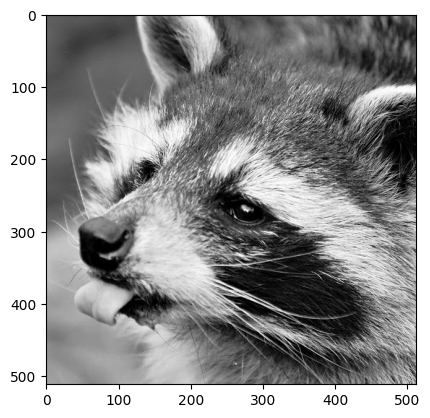

In [59]:
l = np.array(plt.imread("raccoon.jpg"))
# converts the image to grayscale
x = np.sum(l * (0.299, 0.587, 0.113), axis=-1)
x = np.array(x, dtype=np.uint8)

plt.imshow(x, cmap = cm.Greys_r)
plt.show()

### Task 2.1

Break up the image shown below into $1024$ chunks of size $256$ each.

*Hint:* You should only need one line for this part.

In [60]:
image_data = x[:, :]
size_of_packet = 256 
num_of_packets = 1024
assert np.prod(image_data.shape) == size_of_packet * num_of_packets

chunks = image_data.reshape((num_of_packets,size_of_packet))

In [61]:
# Returns a tuple (packets sent, intermediate image every 512 packets + final image, chunks decoded every 64 packets)
def send(tx, rx, verbose=False):
    """
    Repeatedly sends packets from the transmitter to the 
    receiver until all chunks have been decoded or
    the maximum threshold has been reached.
    """
    threshold = rx.num_chunks * 20
    num_sent = 0
    images = []
    chunks_decoded = []
    while not rx.isDone():
        tx.transmit_one_packet(num_sent)
        rx.receive_packet()
        if num_sent % 512 == 0:
            images.append(np.array(rx.chunks.reshape((512,512))))
            if verbose:
                print(num_sent, rx.chunksDone())
        if num_sent % 64 == 0:
            chunks_decoded.append(rx.chunksDone())
        num_sent += 1
        if num_sent > threshold:
            print("Ending transmission because too many packets have been sent. This may be caused by a bug in " + 
                  "receive_packet or an inefficient custom strategy.")
            break
            
    chunks_decoded.append(rx.chunksDone())
    images.append(rx.chunks.reshape((512,512)))
    return (num_sent, images, chunks_decoded)

In [62]:
grader.check("q2.1")

q2.1 results: All test cases passed!

Now, using the `single` degree distribution defined in the `Transmitter` class, send the raccoon over a channel with erasure probability 0.2.

How many packets did you need to send?

The number of packets sent: 9308


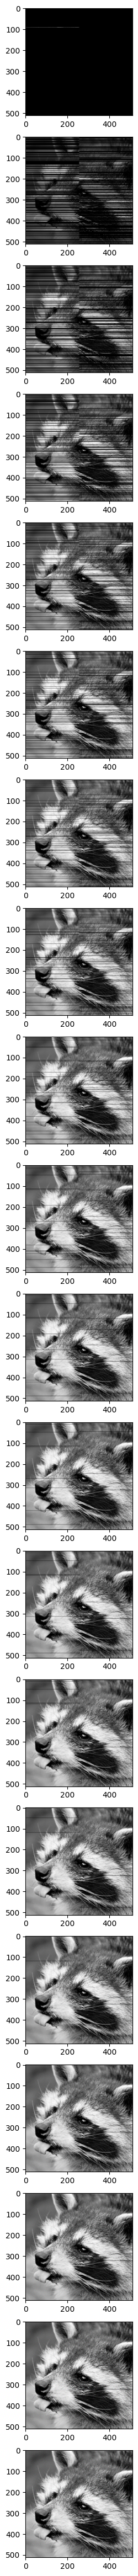

In [63]:
# Set the below values to setup the channel
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'single')
rx = Receiver(len(chunks), ch)

single_sent, images, single_decoded = send(tx,rx)

print("The number of packets sent: {}".format(single_sent))

n_of_figures = len(images)
fig = plt.figure(figsize=(8, 3*n_of_figures))

for i in range(n_of_figures):
    fig.add_subplot(n_of_figures,1,i+1)
    plt.imshow(images[i], cmap = cm.Greys_r)
plt.show()

<!-- BEGIN QUESTION -->

### Task 2.2 (manually graded)

Plot the number of chunks decoded as a function of the number of packets you send.
The `chunks_decoded` array should be helpful here.

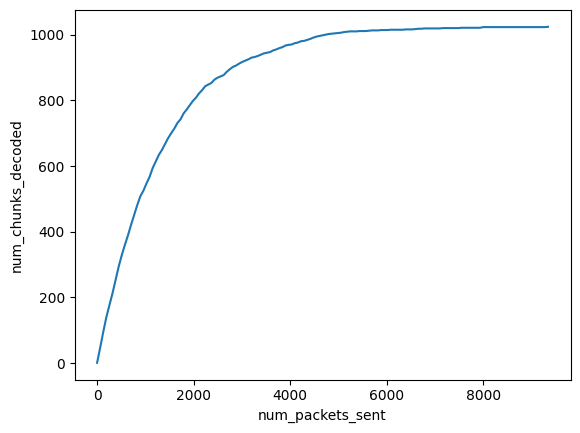

In [64]:
sz=64
num_chunks_decoded = single_decoded
num_packets_sent = list(range(0,single_sent+sz,sz))
plt.plot(num_packets_sent, num_chunks_decoded)
plt.xlabel("num_packets_sent")
plt.ylabel("num_chunks_decoded")
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Task 2.3 (manually graded)
Looking at the graph, we see that it gets harder and harder to find the rest as we decode more and more chunks. Does this remind you of a well known theoretical problem? Which problem is it?

*Hint:* Try out some small examples!

_Type your answer here, replacing this text._

This reminds me of the coupon collector problem.
The kid wants to collect N distinct chunks to have the racoon image.
Each received packet gives information on 1 random chunk.
As you collect more and more new chunks, the probability that a packet contains a new chunks greatly decreases.

<!-- END QUESTION -->

### Task 2.4
Implement the `double` degree distribution in the `Transmitter` class. This distribution will always set the degree $d$ to 2.

Then, run the cell below to check your implementation.

In [65]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Task 2.5 (manually graded)
In the cell below, try to send the raccoon over a channel with erasure probability 0.2 using the `double` degree distribution (don't worry about intermediate plots this time). 

Comment on what happens when you try the `double` degree distribution. Can you tell why this happens?

_Type your answer here, replacing this text._

In the double degree distribution, each packet holds the xor of exactly 2 distinct chunks everytime.
You will unfortunately never be able to deduce the actual value of any single chunk.
You must introduce the probability that some of the packets send only 1 chunk. 
This is a cyclical problem: suppose you know a^b, b^c, and a^c.
Without knowing the value of any of a, b, or c, you won't be able to get any progress!

In [66]:
# YOUR CODE HERE
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'double')
rx = Receiver(len(chunks), ch)

double_sent, images, double_decoded = send(tx,rx)

print("The number of packets sent: {}".format(double_sent))

# n_of_figures = len(images)
# fig = plt.figure(figsize=(8, 3*n_of_figures))

# for i in range(n_of_figures):
#     fig.add_subplot(n_of_figures,1,i+1)
#     plt.imshow(images[i], cmap = cm.Greys_r)
# plt.show()

Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.
The number of packets sent: 20481


<!-- END QUESTION -->

## Q3. Randomized Distributions
You have seen two degree distributions so far.  Both of these have been deterministic, and one worked better than the other.  Let's try a different degree distribution.

<!-- BEGIN QUESTION -->

### Task 3.1 (manually graded)
Implement the `uniform` degree distribution in the `Transmitter` class. 
The `uniform` degree distribution will randomly pick a degree $d$ uniformly at random from $1$ to $5$
(why might it be a good idea to limit the degree to 5?). If we have fewer than $5$ chunks, we will instead pick $d$ uniformly at random from $1$ to the number of chunks.


Next, use the `uniform` degree distribution to send the raccoon over a channel with erasure probability 0.2 over multiple trials. 
For each trial, record the number of packets sent for the image to be decoded. Then, plot this as a histogram.

Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.
Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.
Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.


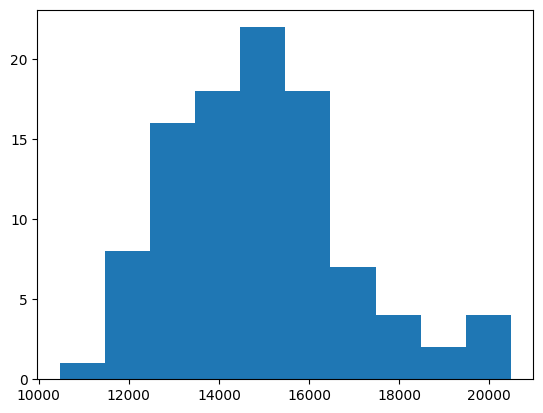

In [67]:
num_trials = 100  # do not change this
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'uniform')

packets_required = []

for _ in range(num_trials):
    rx = Receiver(len(chunks), ch)
    uniform_sent, images, uniform_decoded = send(tx,rx)
    packets_required.append(uniform_sent)
    
    
# Plot the packets required as a histogram
plt.hist(packets_required)
plt.show()

You can run the cell below to check your implementation.

In [68]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

### Task 3.2
Let's examine one final degree distribution. 
The **ideal soliton distribution** is defined as follows:
$$\rho(d) = 
\begin{cases}
\frac{1}{n} & d = 1 \\
\frac{1}{d(d-1)} &d = 2,3,...,n
\end{cases}
$$

This distribution has the nice property that at each decoding step, we can decode 1 new symbol in expectation. Therefore, we might expect to decode the message fully after $n$ decoding steps (in contrast, how many steps would we expect to need with the `single` distribution?).

Implement the `ideal_soliton` degree distribution in the `Transmitter` class. 

*Hint:* As we saw in homework, we can sample from any distribution by sampling a uniform random variable and then applying an inverse CDF. 

*Hint 2*: Can you derive a relatively simple closed form for the ideal soliton CDF? Perform partial fraction decomposition on each term of the PMF and see if you can cancel out terms.

You can run the cell below to check your implementation.

In [69]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Task 3.3 (manually graded)
Using the `ideal_soliton` degree distribution, send the image over a channel with erasure probability 0.2. Plot the number of packets decoded against the number of packets transmitted.

_Type your answer here, replacing this text._

The number of packets sent: 16874


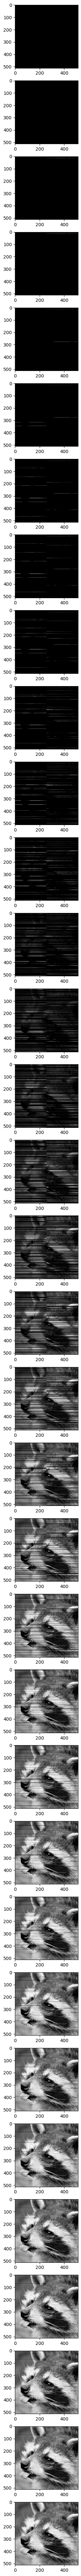

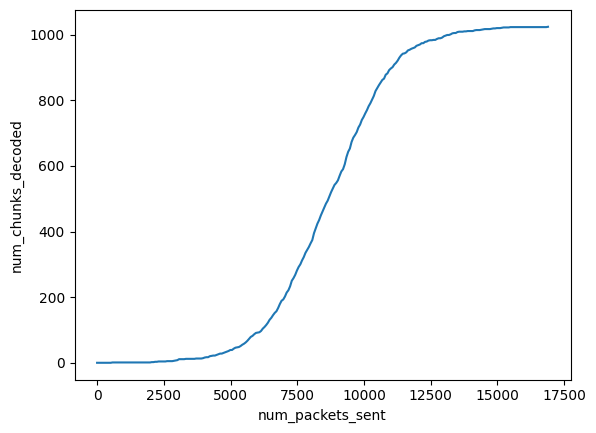

In [70]:
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'ideal_soliton')
rx = Receiver(len(chunks), ch)

sol_sent, images, sol_decoded = send(tx,rx)

print("The number of packets sent: {}".format(sol_sent))

n_of_figures = len(images)
fig = plt.figure(figsize=(8, 3*n_of_figures))

for i in range(n_of_figures):
    fig.add_subplot(n_of_figures,1,i+1)
    plt.imshow(images[i], cmap = cm.Greys_r)
plt.show()

sz=64
num_chunks_decoded = sol_decoded
num_packets_sent = list(range(0,sol_sent+sz,sz))
plt.plot(num_packets_sent, num_chunks_decoded)
plt.xlabel("num_packets_sent")
plt.ylabel("num_chunks_decoded")
plt.show()

<!-- END QUESTION -->

## Optional: Competition Model

Suppose your friend Alice finished her EECS 126 homework early for once and plans to sit down for a movie night (she wants to make use of the 30-day free trial of Netflix!). While Alice is surfing Netflix she decides she wants to stream Interstellar. Alice's laptop drops packets with $p=0.2$. You, the Chief Technology Officer of Netflix, know that given the heavy workload of EECS 126, this may be your only chance to convert this freeloading customer into a permanent one, but to do so you're going to have to make sure her viewing experience is perfect.

### Task 4 (Optional)
Implement the `competition` degree distribution in the `Transmitter` class according to the following rules:

### Concrete specs:

- You are given an erasure channel with drop probability $p=0.2$.
- You must define a degree distribution (which can vary as a function of the # of transmissions already sent) to minimize the number of total packets needed to be sent for the raccoon to be decoded.  Run your code for 100 trials to get a good estimate of the true number of transmissions needed per image while they watch their movies.  Each trial, your score is 

<!-- $$\frac{\text{\# of packets successfully decoded from the first 512 packets}}{512}+\frac{\text{\# of packets successfully decoded from the first 1024 packets}}{1024}+\lfloor\frac{\text{\# of packets successfully decoded from the first 2048 packets}}{1024}\rfloor+\lfloor\frac{\text{\# of packets successfully decoded from the first 4096 packets}}{1024}\rfloor+\lfloor\frac{\text{\# of packets successfully decoded from the first 6144 packets}}{1024}\rfloor$$ -->

$$\sum_{n = \{512, 1024\}} \frac{S(n)}{n} + \sum_{n = \{2048, 4096\}}\left\lfloor \frac{S(n)}{n}\right\rfloor$$

where

$$S(n) = \text{\# of chunks successfully decoded from the first } n \text{ packets}$$

- Note the floor function in the later stages - you can only get the point if you fully decode the file with the alloted number of packets.
- Aim to get a score of at least 3. 
- Hint: most distributions will not be able to score more than 3. See if you can take advantage of properties of the Fountain Code algorithm using the `num_sent` argument of `Transmitter`.


Good luck! 

<!-- *Note that we will be rerunning solutions, so do not cheat.* -->

In [71]:
def score(chunks_decoded):
    c_d = chunks_decoded
    s = c_d[8]/512+c_d[16]/1024
    arr = [33,65,97]
    for i in arr:
        if i >= len(c_d):
            s += 1
    return s

In [72]:
# Test your implementation here!
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'competition')
rx = Receiver(len(chunks), ch)
...

Ellipsis

You can use the following code to score your implementation:

In [73]:
eps = 0.2
ch = Channel(eps)

s_log = []
s = 0
avg = 0
trials = 100
for i in range(trials):
    tx_competition = Transmitter(chunks, ch, 'competition')
    rx = Receiver(len(chunks), ch)
    comp_sent, images, comp_decoded = send(tx_competition,rx)
    s_log.append(s)
    s += score(comp_decoded)
    avg += comp_sent
print("Score: {}".format(s/trials))
print("Sent: {}".format(avg/trials))

Score: 1.209853515625
Sent: 9509.92


## References and Further Reading
[1] D. Mackay.  Information Theory, Inference, and Learning Algorithms. 2003 

[2] D. Mackay. Fountain Codes. 2005. https://docs.switzernet.com/people/emin-gabrielyan/060112-capillary-references/ref/MacKay05.pdf

[3] M. Luby. LT Codes. 2002. https://pages.cs.wisc.edu/~suman/courses/740/papers/luby02lt.pdf

[4] http://blog.notdot.net/2012/01/Damn-Cool-Algorithms-Fountain-Codes 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

This lab will be partially autograded and partially manually (self) graded. This time, you need to submit to **two** Gradescope assignments. Please ensure you submit the ipython notebook (or exported zip file) to the appropriate Gradescope assignment **and** upload a PDF of your lab to the corresponding (separate) Gradescope assignment. 

The export cell will generate a PDF with unnecessary sections filtered out; this is OK as long as all responses and graphs for the manually-graded tasks are visible. If the export cell does not work for you, you may also export the notebook to PDF using a different method and select the appropriate pages on Gradescope. 

**Double-check to ensure that both files are submitted correctly, and ensure any plots we ask you to make are visible in your PDF submission.** We will not give extensions or accommodations for submissions that do not follow these instructions.

In [78]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True, pdf=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2.1 results: All test cases passed!

    q2.4 results: All test cases passed!

    q3.1 results: All test cases passed!

    q3.2 results: All test cases passed!
